In [1]:
import torch 
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import numpy as np
from tqdm import tqdm
import os, time
from datetime import datetime

from skimage.metrics import structural_similarity as ssim_metric
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import normalized_root_mse as nrmse_metric
from torchvision.utils import save_image
from pytorch_fid import fid_score

import pandas as pd

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_latest_checkpoint(checkpoint_dir, model, optimizer):
    """
    가장 최근 수정된 체크포인트(.pth 파일)를 자동으로 찾아서 불러오는 함수입니다.

    Parameters:
    - checkpoint_dir (str): 체크포인트가 저장된 디렉토리 경로
    - model (torch.nn.Module): 학습할 모델 객체
    - optimizer (torch.optim.Optimizer): 옵티마이저 객체

    Returns:
    - int: 저장된 epoch (없으면 0 반환)
    """

    # 1. 디렉토리 내의 .pth 파일 목록을 가져옴
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

    # 2. 체크포인트가 하나도 없으면 경고 출력 후 epoch 0 반환
    if not checkpoint_files:
        print("No Check Point Files. Start New Training.")
        return 0

    # 3. 가장 최근에 수정된 파일을 찾음
    checkpoint_files.sort(key=lambda x: os.path.getmtime(os.path.join(checkpoint_dir, x)), reverse=True)
    latest_checkpoint = os.path.join(checkpoint_dir, checkpoint_files[0])
    print(f"The Latest Check Point: {latest_checkpoint}")

    # 4. 체크포인트 파일 로드
    checkpoint = torch.load(latest_checkpoint)

    # 5. 모델과 옵티마이저에 state_dict 적용
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # 6. 저장된 epoch 반환
    return checkpoint.get('epoch', 0)

In [3]:
torch.__version__

'2.7.0'

In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
# set the random seed
torch.manual_seed(316)

## Load Data

In [6]:
# Device setup
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_device()

transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]
)

### Download

In [7]:
# Dataset
class AlohaImageDataset(Dataset):
    def __init__(self, hf_dataset, camera_key="observation.images.top"):
        self.data = hf_dataset
        self.camera_key = camera_key
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx][self.camera_key]
        image = self.transform(image)
        return image, 0

In [ ]:
dataset = load_dataset("lerobot/aloha_sim_insertion_human_image/")
# dataset = load_dataset("lerobot/aloha_sim_insertion_human_image/episode_000000.parquet")

### Split

In [ ]:
full_dataset = AlohaImageDataset(dataset["train"])

len_trainset = int(len(full_dataset) * 0.8)
len_valset = len(full_dataset) - len_trainset

trainset, valset = random_split(full_dataset, [len_trainset, len_valset])

### Training Set

In [ ]:
# loader for the training set
batch_size = 1
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=False
)

### Validation Set

In [ ]:
# loader for the validation set
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False
)

In [12]:
image, _ = next(iter(trainloader))
print(image.shape)

torch.Size([4, 1, 480, 640])


## Build Neural Network

In [13]:
# Autoencoder
class Autoencoder8x(nn.Module):
    def __init__(self):
        super(Autoencoder8x, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # 28x28 → 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # 14x14 → 7x7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 7x7 → 3x3
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 3x3 → 6x6
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # 6x6 → 12x12
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),   # 12x12 → 24x24
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

model = Autoencoder8x().to(device)
print(model)

Autoencoder8x(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


## Training and Validation

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [15]:
def add_noise(inputs, noise_factor=0.3):
    noised = inputs + torch.randn_like(inputs) * noise_factor
    noised = torch.clip(noised, 0.0, 1.0)
    return noised

### Check point

In [16]:
DATASET = "CNN"
n_epochs = 20
# CKPT_DIR = f"ckpt/{DATASET}_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{n_epochs}"
CKPT_DIR = f"ckpt/{DATASET}"
os.makedirs(CKPT_DIR, exist_ok=True)
ckpt_path = os.path.join(CKPT_DIR, "autoencoder.pth")

start_epoch = 0
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from epoch {start_epoch}")
else:
    print("Starting new training")

Resuming training from epoch 13


In [17]:
# Training
train_loss_history = []
val_loss_history = []
start_time = time.time()

for epoch in tqdm(range(start_epoch, n_epochs)):
    train_loss = 0
    model.train()
    for images, _ in trainloader:
        images = images.to(device)
        # image_noised = add_noise(images)
        output, _ = model(images)
        # denoised, _ = model(image_noised)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(trainloader)
    train_loss_history.append(train_loss)

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, _ in valloader:
            images = images.to(device)
            # image_noised = add_noise(images)
            output, _ = model(images)
            loss = criterion(output, images)
            val_loss += loss.item()
    val_loss /= len(valloader)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, ckpt_path)

print(f"Training complete in {time.time() - start_time:.2f} seconds.")

 14%|█▍        | 1/7 [05:48<34:48, 348.12s/it]

Epoch 14/20 | Train Loss: 0.000 | Val Loss: 0.000


 29%|██▊       | 2/7 [11:26<28:33, 342.61s/it]

Epoch 15/20 | Train Loss: 0.000 | Val Loss: 0.000


 43%|████▎     | 3/7 [17:05<22:43, 340.76s/it]

Epoch 16/20 | Train Loss: 0.000 | Val Loss: 0.000


 57%|█████▋    | 4/7 [22:50<17:07, 342.64s/it]

Epoch 17/20 | Train Loss: 0.000 | Val Loss: 0.000


 71%|███████▏  | 5/7 [28:29<11:22, 341.08s/it]

Epoch 18/20 | Train Loss: 0.000 | Val Loss: 0.000


 86%|████████▌ | 6/7 [34:08<05:40, 340.32s/it]

Epoch 19/20 | Train Loss: 0.000 | Val Loss: 0.000


100%|██████████| 7/7 [1:01:38<00:00, 528.31s/it]

Epoch 20/20 | Train Loss: 0.000 | Val Loss: 0.000
Training complete in 3698.17 seconds.


## Meterics

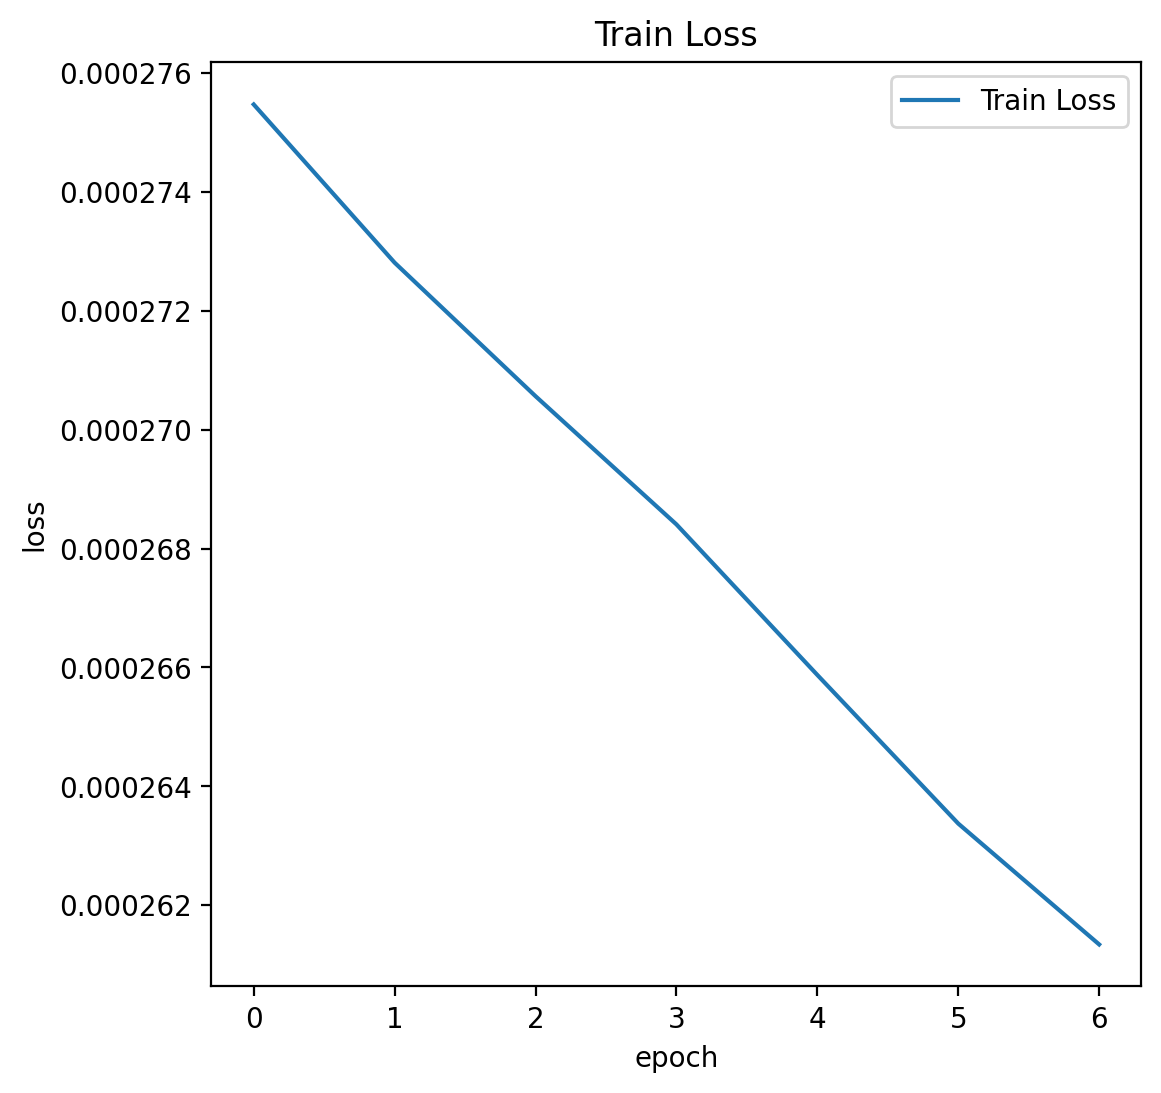

In [18]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss")
ax.legend()

plt.show()

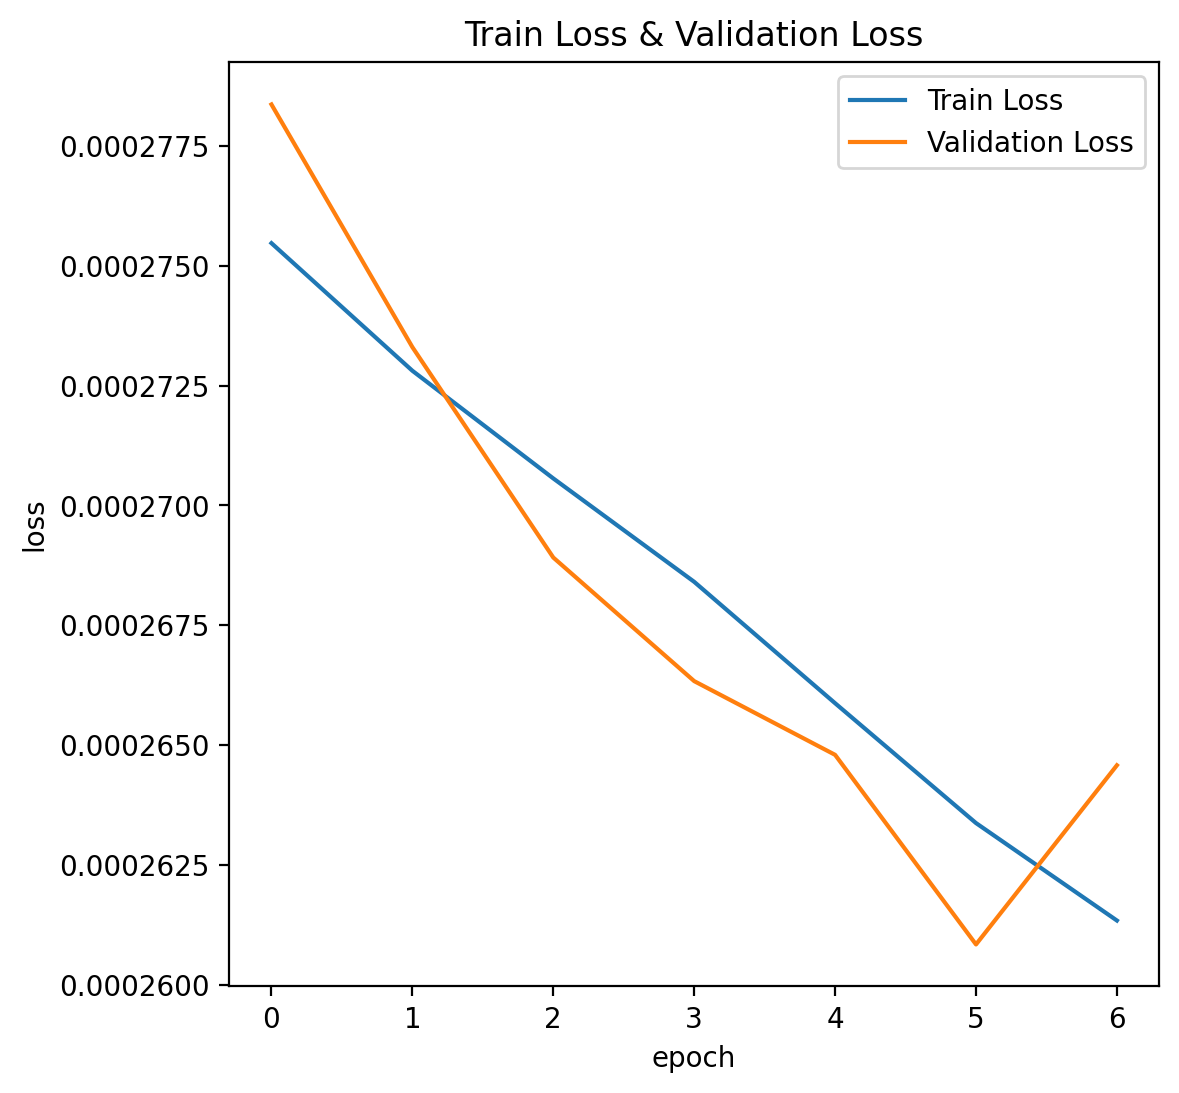

In [19]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(train_loss_history, label="Train Loss")
ax.plot(val_loss_history, label="Validation Loss")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss & Validation Loss")
ax.legend()

plt.show()

## Test

In [20]:
n_test_img = 6

# loader for the testset
testloader = torch.utils.data.DataLoader(
    valset,
    batch_size=n_test_img,
    shuffle=True
)

In [21]:
model.eval()
with torch.no_grad():
    sample_images, _ = next(iter(testloader))  # 배치에서 일부 가져오기
    # sample_images = sample_images.to(device)
    # images_noised = add_noise(sample_images)
    sample_images = sample_images[:8].to(device)
    reconstructed, latent = model(sample_images)

# 압축된 latent space를 480x640으로 업샘플링 (4배 압축 대비)
latent_vis = F.interpolate(latent, size=(480, 640), mode='bilinear', align_corners=False)

# 평가 지표 계산
h, w = 60, 80
FID_REAL = "fid_temp/real_60x80"
FID_FAKE = "fid_temp/fake_60x80"
os.makedirs(FID_REAL, exist_ok=True)
os.makedirs(FID_FAKE, exist_ok=True)

psnr_list, ssim_list, nrmse_list = [], [], []

with torch.no_grad():
    for batch_idx, (images, _) in enumerate(testloader):
        images = images.to(device)
        # noised = add_noise(images) 
        decoded, _ = model(images)

        resized_original = F.interpolate(images, size=(h, w), mode='bilinear', align_corners=False)
        resized_decoded = F.interpolate(decoded, size=(h, w), mode='bilinear', align_corners=False)

        for i in range(images.size(0)):
            save_image(resized_original[i], f"{FID_REAL}/{batch_idx}_{i}.png")
            save_image(resized_decoded[i], f"{FID_FAKE}/{batch_idx}_{i}.png")

        original_np = resized_original.cpu().numpy()
        decoded_np = resized_decoded.cpu().numpy()
        for i in range(images.size(0)):
            psnr_list.append(psnr_metric(original_np[i, 0], decoded_np[i, 0], data_range=1.0))
            ssim_list.append(ssim_metric(original_np[i, 0], decoded_np[i, 0], data_range=1.0))
            nrmse_list.append(nrmse_metric(original_np[i, 0], decoded_np[i, 0]))

fid_val = fid_score.calculate_fid_given_paths([FID_REAL, FID_FAKE], batch_size=32, device=device, dims=2048)
print("=== Autoencoder Reconstruction Metrics ===")
print(f"[{h}×{w}] PSNR={np.mean(psnr_list):.3f}, NRMSE={np.mean(nrmse_list):.3f}, "
      f"SSIM={np.mean(ssim_list):.3f}, FID={fid_val:.3f}")

100%|██████████| 157/157 [01:03<00:00,  2.47it/s]


=== Autoencoder Reconstruction Metrics ===
[60×80] PSNR=39.349, NRMSE=0.042, SSIM=0.996, FID=2.850


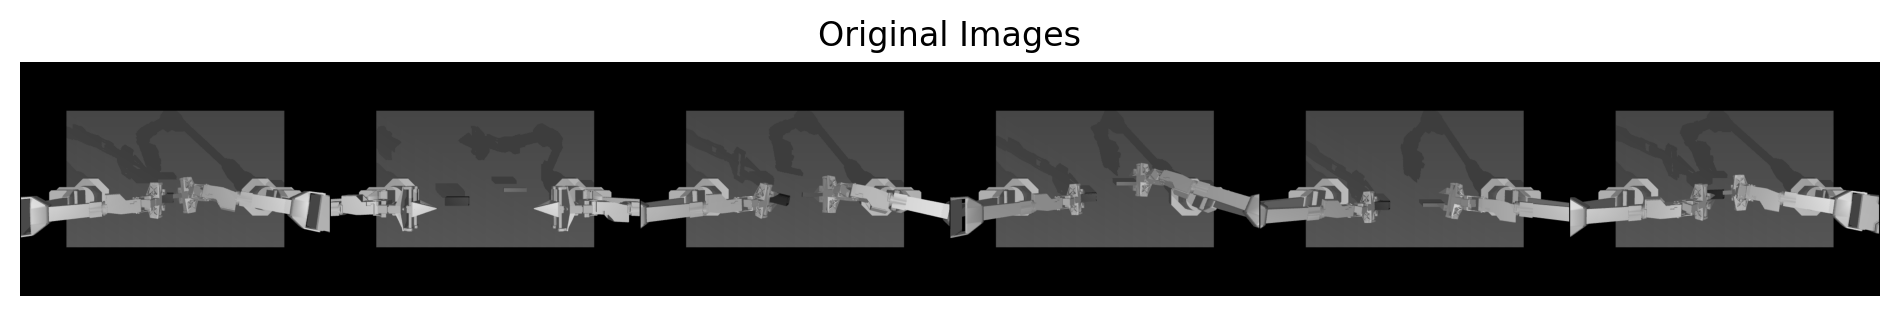

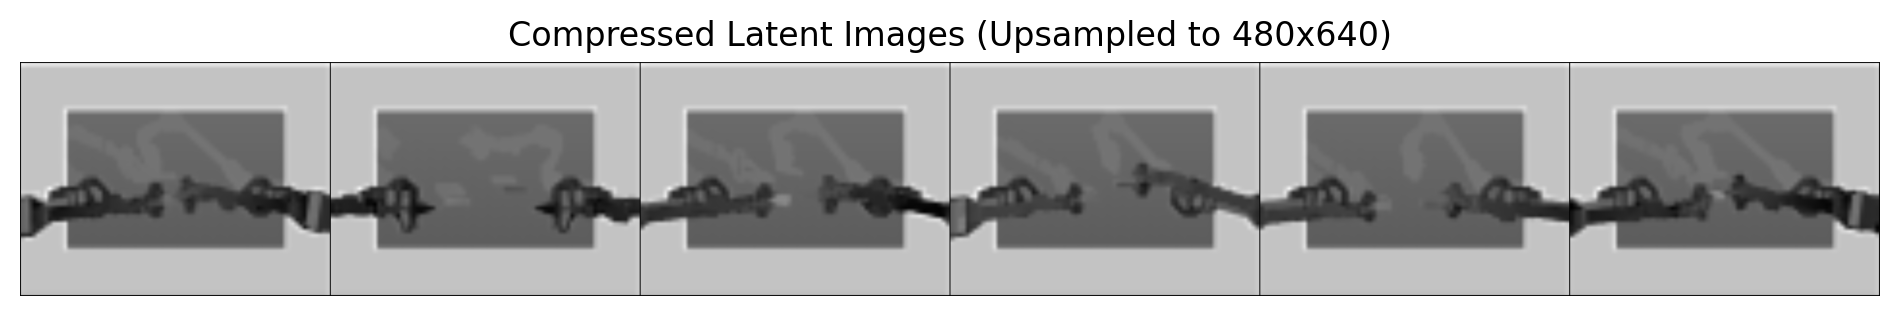

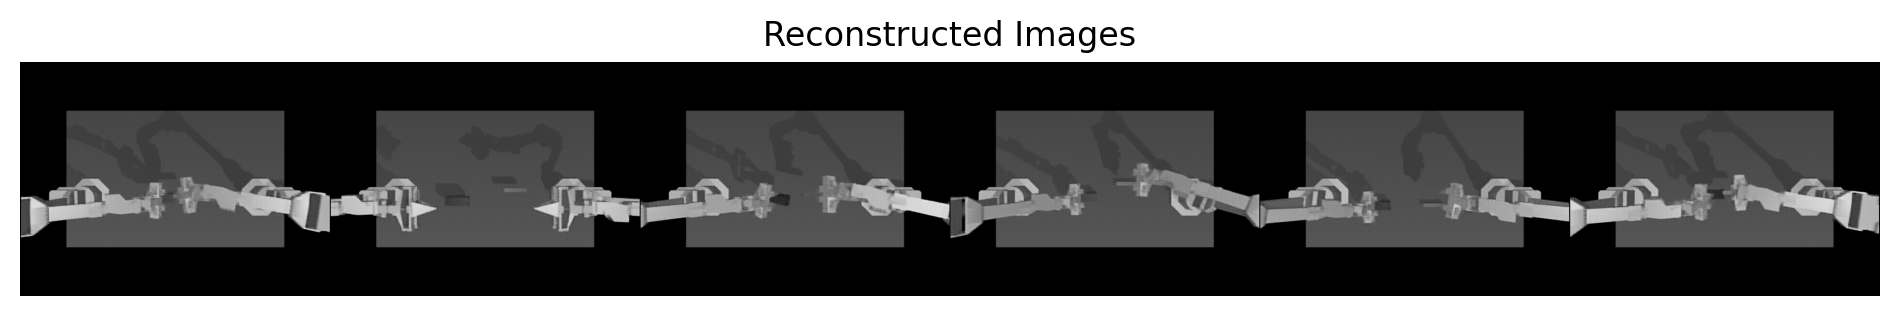

Latent mean min: 1.7496073246002197
Latent mean max: 3.880990743637085


In [25]:
# # 1. 원본 이미지
# plt.figure(figsize=(4, 4))
# plt.imshow(images[0].cpu().squeeze(0), cmap="gray")
# plt.title("Original")
# plt.axis("off")
# plt.show()

# # 2. 압축 이미지 (latent 평균)
# compressed_image = latent_vis[0].cpu().mean(0)
# plt.figure(figsize=(4, 4))
# plt.imshow(compressed_image, cmap="gray")
# plt.title("2x Compressed")
# plt.axis("off")
# plt.show()

# # 3. 복원 이미지
# plt.figure(figsize=(4, 4))
# plt.imshow(denoised[0].cpu().squeeze(0), cmap="gray")
# plt.title("Reconstructed")
# plt.axis("off")
# plt.show()

def show_grid(tensor_batch, title, cmap="gray"):
    """
    입력된 배치 이미지를 1장으로 그리드화하여 시각화.
    """
    grid = make_grid(tensor_batch.cpu(), nrow=8, padding=2)
    plt.figure(figsize=(12, 2))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap=cmap)
    plt.axis("off")
    plt.show()

# === 시각화 ===
# 1. 원본 이미지
show_grid(sample_images, "Original Images")

# 2. 압축된 latent 시각화 (채널 평균 후 업샘플링한 버전)
latent_mean = latent.mean(dim=1, keepdim=True)  # (B, 1, H, W)
# compressed_up = F.interpolate(latent_mean, size=(480, 640), mode='bilinear', align_corners=False)
latent_norm = (latent_mean - latent_mean.min()) / (latent_mean.max() - latent_mean.min() + 1e-8)
compressed_up = F.interpolate(latent_norm, size=(480, 640), mode='bilinear', align_corners=False)
show_grid(compressed_up, "Compressed Latent Images (Upsampled to 480x640)")

# 3. 복원 이미지
show_grid(reconstructed, "Reconstructed Images")

print("Latent mean min:", latent_mean.min().item())
print("Latent mean max:", latent_mean.max().item())

In [26]:
from fvcore.nn import FlopCountAnalysis
from ptflops import get_model_complexity_info

model.eval()

macs, params = get_model_complexity_info(
    model, 
    (1, 480, 640), 
    as_strings=True,
    print_per_layer_stat=False
)

print(f"[ptflops] MACs (FLOPs): {macs}")
print(f"[ptflops] Parameters: {params}")

[ptflops] MACs (FLOPs): 312.12 MMac
[ptflops] Parameters: 8.51 k
